# ChatBot LLM for your own data!

Make sure this has been opened in Google Collab: https://colab.research.google.com/

To run this, you need two things:
1. **A Hugging Face API token.** This sounds complicated, but its just a string of numbers and letters from a website. You go here: https://huggingface.co/join
Then, you go here: https://huggingface.co/settings/tokens and generate an access token. This is the `HuggingFaceAPIKey`.
1. **A pdf file.** This you upload to your "My Drive" location in Google Drive: https://drive.google.com/drive/my-drive. Then write the name of the pdf for the `filename`.


And, *in the interest of speed,* you'll want to follow the next steps:
1. Head to the top right.
1. Find the little arrow (shown below):  
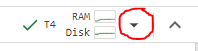
1. Select `Change runtime type`
1. Select `T4 GPU`

### Required Inputs

In [ ]:
# Filename of the PDF (should be located in your "My Drive" Google Drive location)
filename = "filenameofyourpdf.pdf"

# Your API Key
HuggingFaceAPIKey = "YourHuggingFaceAPIKey"

In [ ]:
# Your list of questions

# You can expand/decrease the length of this list, and will scale the output
questions=[
    'Question1?',
      'Question2?',
      'Question3?',
      'Question4?',
      'Question5?',
      ]

In [ ]:
# Mount this to your drive (execute this cell)
from google.colab import drive
drive.mount('/content/drive')

### Setup of Google Drive and Collab

In [ ]:
# Set the folder path where the PDF is
google_drive_path = "/content/drive/MyDrive/" 

# Set the filename to be the same as the above variable
paper_name = filename 

# Combine both
path_to_pdf = [google_drive_path + paper_name] 

# Check: display file path
print(f"Path has been successfully set to: {path_to_pdf}")

In [ ]:
# install required modules
!pip install PdfReader --quiet
!pip install langchain --quiet
!pip install PyPDF2 --quiet
!pip install InstructorEmbedding --quiet
!pip install sentence_transformers --quiet
!pip install faiss --quiet
!pip install faiss-gpu --quiet

print("Require modules have been silently installed.")

In [ ]:
# import required libraries
from PyPDF2 import PdfReader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceInstructEmbeddings
from langchain.vectorstores import FAISS
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFaceHub
import os
from langchain.prompts.prompt import PromptTemplate

print("Require libraries have been silently installed.")

### Define text and chunk functions

In [ ]:
# Function: get text from the PDF
def get_pdf_text(pdf_docs):
  text = ""
  for pdf in pdf_docs:
    
    # Read each pdf
    pdf_reader = PdfReader(pdf) 
    
    # Read each page
    for page in pdf_reader.pages:
      
      # Extract the text from each page
      text += page.extract_text()
  return text

In [ ]:
# Function: chunk text together
# These are hyperparameters that can be adjusted. 
# Some modification may yield better results
def get_text_chunks(text):
  text_splitter = CharacterTextSplitter(
      separator="\n",
      chunk_size=1500,
      chunk_overlap=500,
      length_function=len
  )
  chunks = text_splitter.split_text(text)
  return chunks

In [ ]:
# Function: create embeddings (Hugging Face)
def get_vectorstore(text_chunks):
  embeddings = HuggingFaceInstructEmbeddings(model_name="hkunlp/instructor-xl")
  vectorstore = FAISS.from_texts(texts=text_chunks, embedding=embeddings)
  return vectorstore

In [ ]:
# Function: create a retrival llm chain
# LLM is Falcon 7B parameter model
# Model args can be modified as some alterations may yield better performance.
def retrieval_qa_chain(db, return_source_documents):
  llm = HuggingFaceHub(repo_id="tiiuae/falcon-7b-instruct", model_kwargs={"temperature":0.6,"max_length":1000, "max_new_tokens":1400})
  qa_chain = RetrievalQA.from_chain_type(llm=llm,
                                       chain_type='stuff',
                                       retriever=db,
                                       return_source_documents=return_source_documents,
                                       )
  return qa_chain

In [ ]:
# Set the API key to the one provided above
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HuggingFaceAPIKey

### Digest the PDF

In [ ]:
# Get the raw text from the PDF
raw_text = get_pdf_text(path_to_pdf)

In [ ]:
# Get the text chunks
text_chunks = get_text_chunks(raw_text)

In [ ]:
# Create vector store
vectorstore = get_vectorstore(text_chunks)

In [ ]:
# Create a vector database with similarity search and get the 3 best matched vectors
db = vectorstore.as_retriever(search_kwargs={'k':3})

In [ ]:
# Pass the database to bot as input and initialise
bot = retrieval_qa_chain(db,True)

### Respond to the questions

In [ ]:
# Loops through, printing your question and its answers
for i in range(len(questions)):
  sol = bot(questions[i])
  print(f"QUESTION {i+1}: {questions[i]}")
  print(f"ANSWER {i+1}: {sol['result']}\n")